# **I. READING SATELLITE IMAGES FROM SENTINEL-2 & LandSat-8**

Reading data from these 

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import xarray as xr
import dask
import dask.array
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import pystac_client
import planetary_computer 
from odc.stac import stac_load

In [4]:
# Define the bounding box for our area of interest (Bronx & Manhattan of New York) & time window: between 01-Jun-21 & 01-Sept-21
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-06-01/2021-09-01"

In [5]:
# Download collection of Sentinel-2 images with pre-defined condition
import pystac_client
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=['sentinel-2-l2a'],
    query={"eo:cloud_cover": {"lt": 30}},
)
items = list(search.get_items())

Now that we retrieved **metadata** of sentinel 2 images, we need to download them

In [6]:
# Download the GeoTIFF from server
import planetary_computer
signed_items = [planetary_computer.sign(item).to_dict() for item in items]
resolution = 10
scale = resolution/111320

from odc.stac import stac_load

data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)


In [7]:
data.info()

xarray.Dataset {
dimensions:
	latitude = 1448 ;
	longitude = 1671 ;
	time = 10 ;

variables:
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:resolution = -8.983111749910169e-05 ;
		latitude:crs = EPSG:4326 ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:resolution = 8.983111749910169e-05 ;
		longitude:crs = EPSG:4326 ;
	int32 spatial_ref() ;
		spatial_ref:spatial_ref = GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.01745329251994

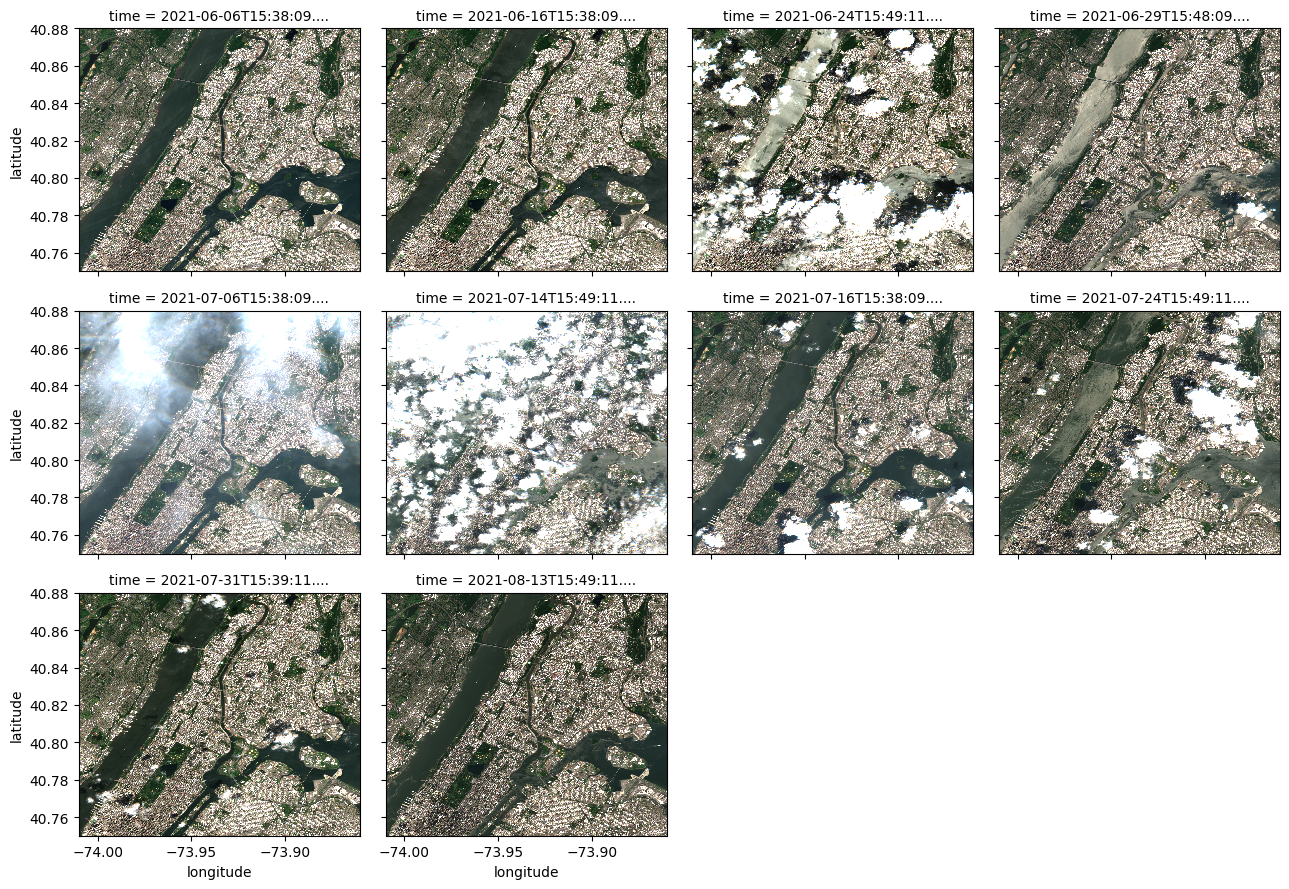

In [8]:
# Create an RGB composite by selecting bands for Red, Green, and Blue
plot_data = data[["B04", "B03", "B02"]].to_array().compute()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

In [9]:
import dask, xarray
print("Dask version:", dask.__version__)
print("xarray version:", xarray.__version__)

Dask version: 2024.10.0
xarray version: 2025.1.1
